### Load the Commit Statistics

In [1]:
project_root_path = '../../..'
lib_path = project_root_path + '/python/lib/'
import json
import sys
sys.path.append(lib_path)
import commit_stats
import feature_map
dataset_dir = project_root_path + '/data/github/2022-04-07-marine-search'
project_stats_dir = dataset_dir + '/projects'
all_commit_stats = commit_stats.load_commit_stats('commit-stat.log.json', project_stats_dir)
all_commit_features = feature_map.get_commit_features(all_commit_stats)
#all_commit_features[slice(2)]

### Load the Manual Labels
commit_labelling.csv is a manual labelling of 160 commits, done with an assist from the output of the clustering notebook.

In [2]:
import pandas as pd

labeling_path = project_root_path + '/sandbox/data/bob/commit_labeling.csv'
data_df = pd.read_csv(labeling_path, sep='\t', index_col=0)
data_df

,label,clstr,binF,txtF,txt,js,rust,md,json,img,lock,html
ab05ef8f08f34b3b39585c0367afb83b9d658f9c,bulk,1,82,39069,5658518,66.62,0.00,6.43,16.36,25,0.44,0.30
48fb8bb782cd493cb4b41e1e21488ba8acd3b507,bulk,1,0,38948,5636363,66.74,0.00,6.45,16.42,15,0.21,0.30
5629c4b1eae0d9db3dd25e5ada2d91393005a3d0,bulk,1,62,789,402917,2.46,2.09,1.45,91.66,48,0.00,0.84
fdb28fe4084b7f182c3da9a8966d6142dd96dfe1,bulk,1,31,411,220745,2.38,1.92,1.27,92.19,23,0.00,0.87
0730644dc859d5395f1ab8f614bbc83903a5d6e0,bulk,1,28,389,201204,2.46,2.07,1.40,91.76,21,0.00,0.85
...,...,...,...,...,...,...,...,...,...,...,...,...
29f15f2b4e404816ea805b610c7ad3432127fdad,rust_pack,3,0,5,75,0.00,64.00,0.00,0.00,0,29.33,0.00
01cdb26c2cb0207abb915703b203fca8fae114dd,rust_pack,3,0,2,56,0.00,3.57,0.00,0.00,0,96.42,0.00
8eb4a1da7c024d1fd9261b4da1a68f0c40d4e375,rust_pack,3,0,7,52,0.00,42.30,0.00,0.00,0,42.30,0.00
6df4e470d37bdbfeb128e55815e73f7ab34fbaeb,rust_pack,3,0,4,51,0.00,7.84,21.56,0.00,0,70.58,0.00


### Link Manual Labels to Feature Stats
Supervised learning traditionally uses X for features and y for targets. Matrices are notated in capital letters, vectors in lowercase.

X is the matrix of input features, with one row per observation and one column per feature.

y is the vector of labeled target values with one value for each observation. In some multiclass and multioutput cases, we would use a matrix Y instead.

In [3]:
import numpy as np

features = ['binFiles','textFiles','textLines','javascriptLines','rustLines',
            'lockLines','htmlLines','jsonLines','markdownLines','imgFiles']

def make_feature_vector(commit_features):
    return [np.log1p(commit_features[feature]) for feature in features]

features_dict = {}
for commit_features in all_commit_features:
    commit_id = commit_features['commit']
    features_dict[commit_id] = commit_features

X = []
y = []
for commit_id, labelling_spreadsheet_row in data_df.iterrows():
    commit_stats = features_dict[commit_id]
    feature_vector = make_feature_vector(commit_stats)
    target_label = labelling_spreadsheet_row[0]
    X.append(feature_vector)
    y.append(target_label)

### Neural Network Classifier
Multilayer Perceptrons (MLPs) are cool. They are neural networks with hidden layers that identify subtle patterns in data across multiple input features. Think about looking at multiple pixels in an image simultaneously to recognize a shape, like a wheel. That is the kind of problem at which neural networks justify their high training cost.

This is not that kind of problem. But NNs are fun, so I'm training one anyway. :)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

random_state = 0
split = train_test_split(X, y, test_size=0.33, random_state=random_state)
X_train, X_test, y_train, y_test = split
clf = MLPClassifier(solver='lbfgs', alpha=1e-3,
                    hidden_layer_sizes=(20,20,20,20),
                    random_state=random_state, max_iter=10000)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
y_pred = clf.predict(X)
print('Score: ' + str(score))

Score: 0.8679245283018868


### Reliable Workhorse Classifier
If neural networks are the awesome hotness of ML algorithms, Linear Regression and it's classifier sibling, Logistic Regression (sometimes abbreviated as Logit), are the reliable workhorses. Even in data science projects that end with a more advanced classifier, Logit is frequently used to give a baseline score during early analysis.

In cases like we have here, with independent features that are mostly correlated to one or two classes, LogisticRegression gets a good answer with very little compute.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

random_state = 0
split = train_test_split(X, y, test_size=0.33, random_state=random_state)
X_train, X_test, y_train, y_test = split
clf = LogisticRegression(random_state=random_state, max_iter=10000)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
print('Score: ' + str(score))
print('size: ' + str(len(X)))

Score: 0.8867924528301887
size: 320


### Cross Validation

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
random_state = 0
clf = LogisticRegression(random_state = random_state, max_iter=10000)
cv_results = cross_validate(clf, X, y, cv=5)
cv_results['test_score']

array([0.828125, 0.890625, 0.921875, 0.96875 , 0.796875])

### Confusion Matrix
Each row of a confusion matrix shows statistics about one of the target classes. The values in the columns show the number of times that the classifier thought a commit of that type was something else.

In [7]:
from sklearn.metrics import confusion_matrix
target_names = list(set(y))
y_test_numeric = [target_names.index(prediction) for prediction in y_test]
y_pred_numeric = [target_names.index(prediction) for prediction in y_pred]
confusion_mx = confusion_matrix(y_test_numeric, y_pred_numeric)
print(target_names)
confusion_mx

['javascript', 'interface', 'minor', 'bulk', 'documentation', 'json', 'other', 'rust', 'json_big', 'rust_pack']


array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 16,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  7,  0,  1,  0,  0,  1,  0,  0],
       [ 0,  1,  0, 30,  0,  1,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  8,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  1,  0,  3,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 11,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  4,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  8]])

### Beautiful Confusion
The numbers above are fine if you want something that can be sent over telex, but we can make it a bit prettier.

The diagonal of accurate predictions is nice and solid. The confusion points are reasonable and we're not seeing major errors, like confusing Rust commits with Javascript. This result is very good. We can proceed to adding a broader selection of project types in the next iteration.

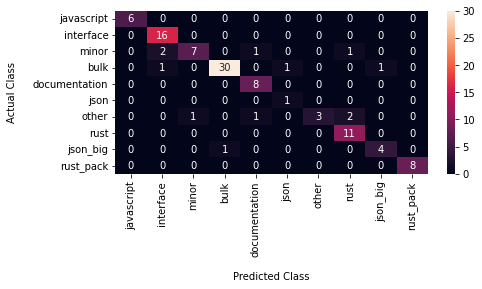

In [8]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
confusion_df = pd.DataFrame(confusion_mx, index=target_names, columns=target_names)
plt.figure(figsize = (7,3))
ax = sn.heatmap(confusion_df, annot=True)
ax.set_xlabel("\nPredicted Class")
ax.set_ylabel("Actual Class\n")
plt.show()